In [80]:
from model import Kronos, KronosTokenizer, KronosPredictor

# Load from Hugging Face Hub
tokenizer = KronosTokenizer.from_pretrained("NeoQuasar/Kronos-Tokenizer-base")
model = Kronos.from_pretrained("NeoQuasar/Kronos-base")

# Initialize the predictor
predictor = KronosPredictor(model, tokenizer, device="cpu", max_context=512)


In [81]:
from matplotlib import pyplot as plt


def plot_prediction(kline_df, pred_df):
    pred_df.index = kline_df.index[-pred_df.shape[0] :]
    sr_close = kline_df["close"]
    sr_pred_close = pred_df["close"]
    sr_close.name = "Ground Truth"
    sr_pred_close.name = "Prediction"

    sr_volume = kline_df["volume"]
    sr_pred_volume = pred_df["volume"]
    sr_volume.name = "Ground Truth"
    sr_pred_volume.name = "Prediction"

    close_df = pd.concat([sr_close, sr_pred_close], axis=1)
    volume_df = pd.concat([sr_volume, sr_pred_volume], axis=1)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

    ax1.plot(
        close_df["Ground Truth"], label="Ground Truth", color="blue", linewidth=1.5
    )
    ax1.plot(close_df["Prediction"], label="Prediction", color="red", linewidth=1.5)
    ax1.set_ylabel("Close Price", fontsize=14)
    ax1.legend(loc="lower left", fontsize=12)
    ax1.grid(True)

    ax2.plot(
        volume_df["Ground Truth"], label="Ground Truth", color="blue", linewidth=1.5
    )
    ax2.plot(volume_df["Prediction"], label="Prediction", color="red", linewidth=1.5)
    ax2.set_ylabel("Volume", fontsize=14)
    ax2.legend(loc="upper left", fontsize=12)
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [115]:
stock_data = pd.read_csv(
    "./data/2025-09-23/stock_data_sh.000001_上证综合指数_2024-04-28_2025-09-22.csv"
)

FileNotFoundError: [Errno 2] No such file or directory: './data/2025-09-23/stock_data_sh.000001_上证综合指数_2024-04-28_2025-09-22.csv'

In [116]:
stock_data.tail()

,date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,peTTM,pbMRQ,psTTM,pcfNcfTTM,isST
676,2025-09-16,sh.000001,3865.9801,3876.6901,3838.6483,3861.8651,3860.5036,67343972300,9.897861e+11,3,1.418245,1,0.035267,0.0,0.0,0.0,0.0,0
677,2025-09-17,sh.000001,3854.0726,3882.6687,3848.9455,3876.3409,3861.8651,66343471300,1.006679e+12,3,1.388045,1,0.374840,0.0,0.0,0.0,0.0,0
678,2025-09-18,sh.000001,3876.0592,3899.9594,3800.9953,3831.6562,3876.3409,87602738900,1.365962e+12,3,1.841579,1,-1.152755,0.0,0.0,0.0,0.0,0
679,2025-09-19,sh.000001,3830.4437,3843.1696,3811.9029,3820.0894,3831.6562,68229261300,1.016348e+12,3,1.434931,1,-0.301875,0.0,0.0,0.0,0.0,0
680,2025-09-22,sh.000001,3822.0096,3831.7404,3806.2016,3828.5764,3820.0894,56832568600,9.418000e+11,3,1.195898,1,0.222168,0.0,0.0,0.0,0.0,0


In [94]:
selected_data = stock_data[["open", "high", "low", "close", "volume","amount"]].reset_index(drop=True)

In [95]:
selected_data = selected_data[len(stock_data) - 512 :]

In [96]:
len(selected_data)

512

In [97]:
x_timestamp = stock_data["date"].reset_index(drop=True)
x_timestamp = x_timestamp[len(stock_data) - 512 :]
x_timestamp = pd.to_datetime(x_timestamp)

In [98]:
len(x_timestamp)

512

In [119]:
dates = pd.bdate_range(start="2025-09-23", end="2025-09-24")


# 将 DatetimeIndex 转换为 Series

y_timestamp_series = pd.Series(dates)

# 查看转换后的 Series
print(y_timestamp_series)

0   2025-09-23
1   2025-09-24
dtype: datetime64[ns]


In [120]:
# Generate predictions
pred_df = predictor.predict(
    df=selected_data,
    x_timestamp=x_timestamp,
    y_timestamp=y_timestamp_series,
    pred_len=len(y_timestamp_series),
    T=1.0,  # Temperature for sampling
    top_p=0.9,  # Nucleus sampling probability
    sample_count=1,  # Number of forecast paths to generate and average
)

print("Forecasted Data Head:")
print(pred_df.head())

100%|██████████| 2/2 [00:00<00:00,  4.75it/s]

Forecasted Data Head:
                   open         high          low        close        volume  \
2025-09-23  3801.941162  3835.949707  3782.326904  3804.324463  5.846841e+10   
2025-09-24  3737.037109  3780.006104  3683.488281  3739.459473  6.585211e+10   

                  amount  
2025-09-23  7.812145e+11  
2025-09-24  8.667084e+11  


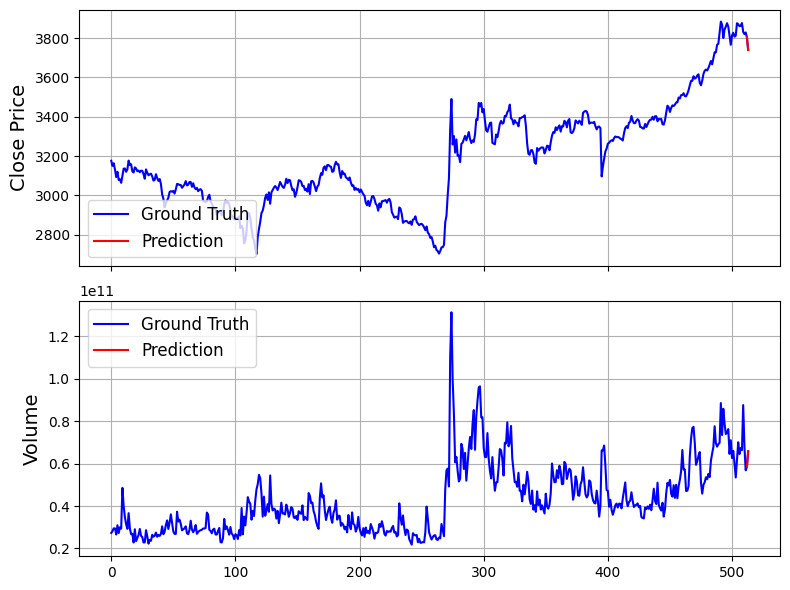

In [121]:
selected_data = selected_data.reset_index(drop=True)
pred_df = pred_df.reset_index(drop=True)
all_df = pd.concat([selected_data, pred_df], axis=0, ignore_index=True)
plot_prediction(all_df, pred_df)

In [79]:
pred_df["close"].min()

3087.585205078125

In [74]:
import baostock as bs
import pandas as pd

#### 登陆系统 ####
lg = bs.login()
# 显示登陆返回信息
print("login respond error_code:" + lg.error_code)
print("login respond  error_msg:" + lg.error_msg)

#### 获取交易日信息 ####
rs = bs.query_trade_dates(start_date="2025-09-23", end_date="2026-09-30")
print("query_trade_dates respond error_code:" + rs.error_code)
print("query_trade_dates respond  error_msg:" + rs.error_msg)

#### 打印结果集 ####
data_list = []
while (rs.error_code == "0") & rs.next():
    # 获取一条记录，将记录合并在一起
    data_list.append(rs.get_row_data())
result = pd.DataFrame(data_list, columns=rs.fields)

#### 结果集输出到csv文件 ####

print(result)

#### 登出系统 ####
bs.logout()

login success!
login respond error_code:0
login respond  error_msg:success
query_trade_dates respond error_code:0
query_trade_dates respond  error_msg:success
   calendar_date is_trading_day
0     2025-09-23              1
1     2025-09-24              1
2     2025-09-25              1
3     2025-09-26              1
4     2025-09-27              0
..           ...            ...
95    2025-12-27              0
96    2025-12-28              0
97    2025-12-29              1
98    2025-12-30              1
99    2025-12-31              1

[100 rows x 2 columns]
logout success!


In [3]:
import baostock as bs
import pandas as pd

#### 登陆系统 ####
lg = bs.login()
# 显示登陆返回信息
print("login respond error_code:" + lg.error_code)
print("login respond  error_msg:" + lg.error_msg)

#### 获取某日所有证券信息 ####
rs = bs.query_all_stock(day="2024-10-25")
print("query_all_stock respond error_code:" + rs.error_code)
print("query_all_stock respond  error_msg:" + rs.error_msg)

#### 打印结果集 ####
data_list = []
while (rs.error_code == "0") & rs.next():
    # 获取一条记录，将记录合并在一起
    data_list.append(rs.get_row_data())
result = pd.DataFrame(data_list, columns=rs.fields)

#### 结果集输出到csv文件 ####
result.to_csv("D:\\all_stock.csv", encoding="utf-8", index=False)
print(result)

#### 登出系统 ####
bs.logout()

login success!
login respond error_code:0
login respond  error_msg:success
query_all_stock respond error_code:0
query_all_stock respond  error_msg:success
           code tradeStatus   code_name
0     sh.000001           1      上证综合指数
1     sh.000002           1      上证A股指数
2     sh.000003           1      上证B股指数
3     sh.000004           1     上证工业类指数
4     sh.000005           1     上证商业类指数
...         ...         ...         ...
5641  sz.399994           1  中证信息安全主题指数
5642  sz.399995           1    中证基建工程指数
5643  sz.399996           1    中证智能家居指数
5644  sz.399997           1      中证白酒指数
5645  sz.399998           1      中证煤炭指数

[5646 rows x 3 columns]
logout success!


In [ ]:
for idx,data in result.iterrows():
    print(data.)

sh.000001
sh.000002
sh.000003
sh.000004
sh.000005
sh.000006
sh.000007
sh.000008
sh.000009
sh.000010
sh.000011
sh.000012
sh.000013
sh.000015
sh.000016
sh.000017
sh.000018
sh.000019
sh.000020
sh.000021
sh.000022
sh.000025
sh.000026
sh.000027
sh.000028
sh.000029
sh.000030
sh.000031
sh.000032
sh.000033
sh.000034
sh.000035
sh.000036
sh.000037
sh.000038
sh.000039
sh.000040
sh.000041
sh.000042
sh.000043
sh.000044
sh.000045
sh.000046
sh.000047
sh.000048
sh.000049
sh.000050
sh.000051
sh.000052
sh.000053
sh.000054
sh.000056
sh.000057
sh.000058
sh.000059
sh.000060
sh.000061
sh.000062
sh.000063
sh.000064
sh.000065
sh.000066
sh.000067
sh.000068
sh.000069
sh.000070
sh.000071
sh.000072
sh.000073
sh.000074
sh.000075
sh.000076
sh.000077
sh.000078
sh.000079
sh.000090
sh.000091
sh.000092
sh.000093
sh.000094
sh.000095
sh.000096
sh.000097
sh.000098
sh.000099
sh.000100
sh.000101
sh.000102
sh.000103
sh.000104
sh.000105
sh.000106
sh.000107
sh.000108
sh.000109
sh.000110
sh.000111
sh.000112
sh.000113
sh.000114
